<a href="https://colab.research.google.com/github/piku0806/C84/blob/main/KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all libraries and bbc_news_data**

In [9]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import itertools

# Load your dataset
bbc_news_data = pd.read_csv("/content/system_data.csv")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
bbc_news_data.shape

(35000, 5)

**Load bbc_news and plot main KG**

In [ ]:
# Create a graph
G = nx.Graph()

# Extract named entities from the descriptions
for description in bbc_news_data['description']:
    if pd.isna(description):  # Check for NaN values
        continue  # Skip this iteration if description is NaN
    doc = nlp(description)
    entities = [ent.text for ent in doc.ents if ent.label_ in ('PERSON', 'ORG', 'GPE')]  # Filter for relevant entities
    for i, ent1 in enumerate(entities):
        for ent2 in entities[i + 1:]:
            if G.has_edge(ent1, ent2):
                G[ent1][ent2]['weight'] += 1
            else:
                G.add_edge(ent1, ent2, weight=1)

# Plotting the main graph
plt.figure(figsize=(12, 4))
pos = nx.spring_layout(G, k=0.5)  # Position the nodes
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, alpha=0.5)
plt.title("Main Knowledge Graph")
plt.show()


**Extract new entities from one line of text**

In [ ]:
new_text = pd.read_csv("/content/change_data.csv")

doc = nlp(new_text)

new_entities = [ent.text for ent in doc.ents if ent.label_ in ('PERSON', 'ORG', 'GPE')]

print("Extracted Entities:", new_entities)

Extracted Entities: ['Ukraine', 'UK']


**idk what the purpose of this is**

In [ ]:
# Create a graph
G = nx.Graph()

# Function to extract entities and update the graph
def update_graph_with_entities(text, graph):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract relevant named entities (PERSON, ORG, GPE)
    entities = [ent.text for ent in doc.ents if ent.label_ in ('PERSON', 'ORG', 'GPE')]
    # Add entities and relationships to the graph
    for i, ent1 in enumerate(entities):
        for ent2 in entities[i + 1:]:
            if graph.has_edge(ent1, ent2):
                graph[ent1][ent2]['weight'] += 1
            else:
                graph.add_edge(ent1, ent2, weight=1)
    return entities  # Return the extracted entities for later use


# Process each description from the dataset and update the main graph
for description in bbc_news_data['description']:
    if pd.isna(description):  # Check for NaN values
        continue  # Skip this iteration if description is NaN
    update_graph_with_entities(description, G)

# Now process the new text and update the graph
new_text = "Ukraine: Ministers can now detain Russian planes in UK"
new_entities = update_graph_with_entities(new_text, G)

**Create 1-hop subgraph (incorrectly labeled as subgraph)**

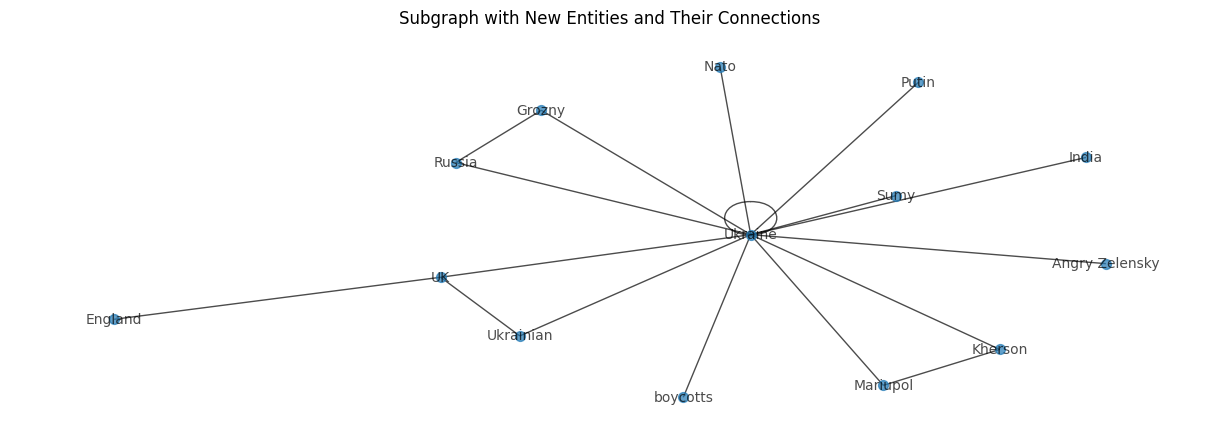

In [ ]:
# Create a subgraph with the new entities and their connected nodes
def create_subgraph(graph, entities):
    # Collect nodes that are the new entities or connected to them
    subgraph_nodes = set()
    for entity in entities:
        if entity in graph:
            # Add the entity itself and all its neighbors (connected nodes)
            subgraph_nodes.add(entity)
            subgraph_nodes.update(nx.neighbors(graph, entity))
    # Create and return the subgraph
    return graph.subgraph(subgraph_nodes)

# Create the subgraph based on the new entities
subgraph = create_subgraph(G, new_entities)

# Plot the subgraph
plt.figure(figsize=(12, 4))
pos_sub = nx.spring_layout(subgraph, k=0.5)  # Position the nodes
nx.draw(subgraph, pos_sub, with_labels=True, node_size=50, font_size=10, alpha=0.7)
plt.title("Subgraph with New Entities and Their Connections")
plt.show()


**Create text subgraph (incorrectly labeled as hop graph in code)**

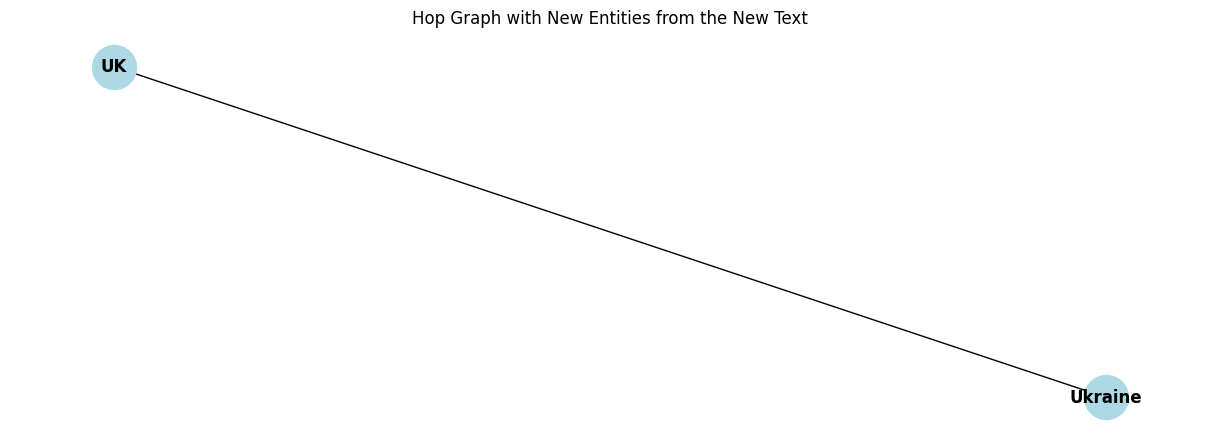

In [ ]:
# Function to extract entities and create a new hop graph
def create_hop_graph_from_new_text(text):
    # Create a new graph
    hop_graph = nx.Graph()

    # Process the text with spaCy
    doc = nlp(text)

    # Extract relevant named entities (PERSON, ORG, GPE)
    new_entities = [ent.text for ent in doc.ents if ent.label_ in ('PERSON', 'ORG', 'GPE')]

    # Add the new entities and relationships to the new graph
    for i, ent1 in enumerate(new_entities):
        for ent2 in new_entities[i + 1:]:
            # Create an edge between entities if they co-occur
            if hop_graph.has_edge(ent1, ent2):
                hop_graph[ent1][ent2]['weight'] += 1  # Increment weight if already connected
            else:
                hop_graph.add_edge(ent1, ent2, weight=1)  # Create a new edge

    return hop_graph

# The new text
new_text = "Ukraine: Ministers can now detain Russian planes in UK"

# Create the hop graph for the new entities from the new text
hop_graph = create_hop_graph_from_new_text(new_text)

# Plot the hop graph with the new entities
plt.figure(figsize=(12, 4))
pos_hop = nx.spring_layout(hop_graph, k=0.5)  # Position the nodes
nx.draw(hop_graph, pos_hop, with_labels=True, node_size=1000, font_size=12, node_color="lightblue", font_weight="bold")
plt.title("Hop Graph with New Entities from the New Text")
plt.show()

**I have no clue what this is**

In [ ]:
# Create the overall graph (G)
G = nx.Graph()

# Add all dataset descriptions to the overall graph
for description in bbc_news_data['title']:
    if pd.isna(description):  # Check for NaN values
        continue  # Skip this iteration if description is NaN
    update_graph_with_entities(description, G)

# New text
new_text = "Ukraine: Ministers can now detain Russian planes in UK"
new_entities = update_graph_with_entities(new_text, G)


# Function to create a hop graph with only the new entities
def create_hop_graph(graph, entities):
    hop_graph_nodes = set(entities)
    return graph.subgraph(hop_graph_nodes)

# Create the hop graph
hop_graph = create_hop_graph(G, new_entities)

# Print list of nodes in the subgraph
subgraph_nodes = list(subgraph.nodes())
print("List of nodes in the subgraph (new entities + their connections):")
print(subgraph_nodes)

# Print list of nodes in the hop graph
hop_graph_nodes = list(hop_graph.nodes())
print("\nList of nodes in the hop graph (only new entities):")
print(hop_graph_nodes)

List of nodes in the subgraph (new entities + their connections):
['Russia', 'Sumy', 'boycotts', 'Nato', 'Kherson', 'Angry Zelensky', 'Ukrainian', 'Putin', 'Mariupol', 'England', 'Ukraine', 'India', 'Grozny', 'UK']

List of nodes in the hop graph (only new entities):
['Ukraine', 'UK']


**Retrieve the list of explicit & implicit relations from text and 1-hop subgraph**

In [ ]:
explicit_relations = []
for node1, node2 in itertools.combinations(hop_graph_nodes, 2):
    explicit_relations.append(tuple(sorted((node1, node2))))

# Display the list of possible relationships
print(len(explicit_relations),"Explicit Relations")
for relationship in explicit_relations:
    print(relationship)

all_relations = []
for node1, node2 in itertools.combinations(list(subgraph_nodes), 2):
    all_relations.append(tuple(sorted((node1, node2))))

implicit_relations = set(all_relations) - set(explicit_relations)

print(len(implicit_relations), 'Implicit Relations','\n', implicit_relations)

1 Explicit Relationships
('UK', 'Ukraine')
90 Implicit Relations 
 {('Angry Zelensky', 'Russia'), ('Grozny', 'Putin'), ('England', 'Ukraine'), ('Grozny', 'Mariupol'), ('India', 'Putin'), ('India', 'Russia'), ('Nato', 'UK'), ('Mariupol', 'UK'), ('Angry Zelensky', 'boycotts'), ('UK', 'boycotts'), ('Mariupol', 'Nato'), ('Nato', 'Sumy'), ('India', 'boycotts'), ('Ukraine', 'Ukrainian'), ('Putin', 'UK'), ('Russia', 'Ukrainian'), ('Angry Zelensky', 'UK'), ('Grozny', 'Kherson'), ('Mariupol', 'Ukraine'), ('Kherson', 'Ukrainian'), ('Angry Zelensky', 'Nato'), ('India', 'UK'), ('Russia', 'Sumy'), ('India', 'Nato'), ('Kherson', 'Nato'), ('India', 'Sumy'), ('Kherson', 'Sumy'), ('England', 'Grozny'), ('Putin', 'Ukraine'), ('Angry Zelensky', 'Ukraine'), ('Grozny', 'Ukraine'), ('Ukrainian', 'boycotts'), ('India', 'Ukraine'), ('Sumy', 'Ukraine'), ('England', 'Ukrainian'), ('Angry Zelensky', 'England'), ('Grozny', 'India'), ('England', 'Nato'), ('England', 'Sumy'), ('Angry Zelensky', 'Mariupol'), ('Ukrai